In [ ]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/LPW.zip' -d '/content/drive/MyDrive/Colab Notebooks/LPW' 

In [ ]:
!git clone https://github.com/isohrab/Pupil-locator.git
%cd Pupil-locator

Cloning into 'Pupil-locator'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 538 (delta 2), reused 0 (delta 0), pack-reused 531
Receiving objects: 100% (538/538), 69.26 MiB | 14.27 MiB/s, done.
Resolving deltas: 100% (350/350), done.
/content/Pupil-locator


In [ ]:
import argparse
import os
import time

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from albumentations.pytorch import ToTensorV2
from glob import glob
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.ops import complete_box_iou_loss, distance_box_iou_loss
from tqdm import tqdm

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [ ]:
transform = A.Compose([
    A.CLAHE(p=0.2),
    A.Blur(blur_limit=(7, 7), p=0.2),
    A.GaussNoise(20, p=0.2),
    A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, p=0.2),
    A.Normalize((0.5), (0.5)),
    A.Resize(256, 256),
    ToTensorV2(),
])

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [ ]:
def rescale_bbox(img, bbox, target_size=256):
    y_ = img.shape[0]
    x_ = img.shape[1]

    x_scale = target_size / x_
    y_scale = target_size / y_

    x = int(np.round(bbox[0] * x_scale))
    y = int(np.round(bbox[1] * y_scale))
    r = int(np.round(bbox[2] * x_scale * y_scale))

    return (x, y, r)

In [ ]:
class LPWDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        label_file = os.path.join(self.data_dir, 'label.txt')
        self.df = pd.read_csv(label_file, sep=',', header=None)
        self.image_paths = self.df.iloc[18035: 50000, 0].values
        self.bboxes = self.df.iloc[18035: 50000, 1:4].values

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = rescale_bbox(img, self.bboxes[idx])
        img = self.transform(image=img)['image']
        label = torch.FloatTensor(label) / 255
        return img, label

In [ ]:
dataset = LPWDataset('/content/drive/MyDrive/Colab Notebooks/LPW', transform)

In [ ]:
train_size = int(0.98 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=2)

print(len(train_loader), len(test_loader))

3916 80


In [ ]:
def draw_bbox(img, bbox):
    temp = (img.copy() * 255).astype(np.uint8)
    bbox = bbox * 255
    cv2.drawMarker(temp, (int(bbox[0]), int(bbox[1])), (0, 255, 0), cv2.MARKER_CROSS, 12, 1)
    temp = cv2.circle(temp, (int(bbox[0]), int(bbox[1])), int(bbox[2]), (0, 255, 0), 1)
    return temp

In [ ]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
model.classifier.fc = nn.Linear(1280, 3)

model = model.to(device)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
def iou_loss(outputs, label):
    boxes1 = torch.stack([
        outputs[:, 0] - outputs[:, 2],
        outputs[:, 1] - outputs[:, 2],
        outputs[:, 0] + outputs[:, 2],
        outputs[:, 1] + outputs[:, 2]], dim=1)
    boxes2 = torch.stack([
        label[:, 0] - label[:, 2],
        label[:, 1] - label[:, 2],
        label[:, 0] + label[:, 2],
        label[:, 1] + label[:, 2]], dim=1)
    loss = complete_box_iou_loss(boxes1, boxes2)
    return loss.mean()


optimizer = optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999))
huber_loss = nn.HuberLoss()

In [ ]:
train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(8):
    train_loss = []
    model.train()
    for batch_id, (data, label) in enumerate(tqdm(train_loader)):
        with torch.set_grad_enabled(True):
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            batch_size = data.size(0)
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()

            outputs = model(data)

            loss = huber_loss(outputs, label) + iou_loss(outputs, label)

            loss.backward(retain_graph=True)
            optimizer.step()

            train_loss.append(loss.item())

    train_losses.append(np.mean(train_loss))

    val_loss = []
    model.eval()
    for batch_id, (data, label) in enumerate(tqdm(test_loader)):
        with torch.set_grad_enabled(False):
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            batch_size = data.size(0)
            data, label = data.to(device), label.to(device)

            outputs = model(data)

            loss = huber_loss(outputs, label) + iou_loss(outputs, label)
            val_loss.append(loss.item())
            print('Loss', loss.item())

        if batch_id % 20 == 0:
            try:
                img = data[0].permute(1, 2, 0).cpu().detach().numpy() * 0.5 + 0.5
                # plt.subplot(121)
                bbox = outputs[0].cpu().detach().numpy()
                plt.imshow(draw_bbox(img, bbox))
                plt.axis('off')
                # plt.subplot(122)
                plt.figure()
                bbox = label[0].cpu().detach().numpy()
                plt.imshow(draw_bbox(img, bbox))
                plt.axis('off')
                plt.show()
            except:
                pass
    val_losses.append(np.mean(val_loss))

 35%|███▌      | 1390/3916 [04:23<07:02,  5.98it/s]

In [ ]:
model.eval()

accuracy = []
for epsilon in range(1, 20):
    fuck = []
    you = []
    for batch_id, (data, label) in enumerate(tqdm(test_loader)):
        with torch.set_grad_enabled(False):
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            batch_size = data.size(0)
            data, label = data.to(device), label.to(device)

            outputs = model(data)

            outputs = outputs.cpu().detach().numpy()
            label = label.cpu().detach().numpy()

            error = np.abs(outputs - label) * 255

            fuck.append(np.count_nonzero(error))
            you.append(np.count_nonzero(error < epsilon))
    accuracy.append(np.sum(you) / np.sum(fuck))

100%|██████████| 80/80 [00:11<00:00,  7.10it/s]


Text(0.5, 1.0, 'Detection accuracy')

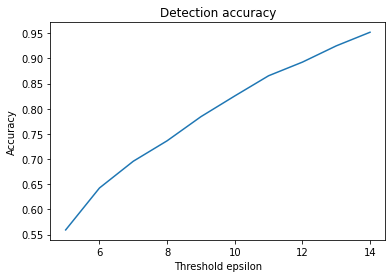

In [ ]:
plt.plot(np.arange(5, 15), accuracy[9:])
plt.xlabel('Threshold epsilon')
plt.ylabel('Accuracy')

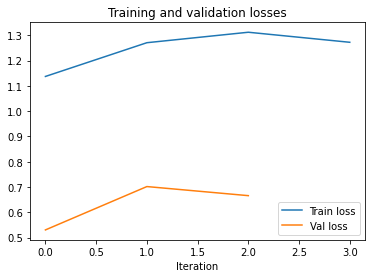

In [ ]:
plt.figure()
plt.title('Training and validation losses')
plt.plot(np.array(train_losses) * 3, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model2.pth')

In [ ]:
1/0

In [ ]:
import tensorflow.compat.v1 as tf
from config import config
from logger import Logger
from models import Simple, NASNET, Inception, GAP, YOLO
from utils import annotator, change_channel, gray_normalizer
tf.disable_v2_behavior()

def crop_frame(frame):
    if len(frame.shape) == 2:
        w, h = frame.shape
    else:
        w, h, c = frame.shape

    left = frame[0:w // 2, 0:h // 2]
    right = frame[0:w // 2, h // 2:]
    return left, right

def load_model(session, m_type, m_name, logger):
    # load the weights based on best loss
    best_dir = "best_loss"

    # check model dir
    model_path = "./models/" + m_name
    path = os.path.join(model_path, best_dir)
    print(path)
    if not os.path.exists(path):
        raise FileNotFoundError

    if m_type == "simple":
        model = Simple(m_name, config, logger)
    elif m_type == "YOLO":
        model = YOLO(m_name, config, logger)
    elif m_type == "GAP":
        model = GAP(m_name, config, logger)
    elif m_type == "NAS":
        model = NASNET(m_name, config, logger)
    elif m_type == "INC":
        model = Inception(m_name, config, logger)
    else:
        raise ValueError

    # load the best saved weights
    ckpt = tf.train.get_checkpoint_state(path)
    if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
        logger.log('Reloading model parameters..')
        model.restore(session, ckpt.model_checkpoint_path)

    else:
        raise ValueError('There is no best model with given model')

    return model


def rescale(image):
    """
    If the input video is other than network size, it will resize the input video
    :param image: a frame form input video
    :return: scaled down frame
    """
    scale_side = max(image.shape)
    # image width and height are equal to 192
    scale_value = config["input_width"] / scale_side

    # scale down or up the input image
    scaled_image = cv2.resize(image, dsize=None, fx=scale_value, fy=scale_value)

    # convert to numpy array
    scaled_image = np.asarray(scaled_image, dtype=np.uint8)

    # one of pad should be zero
    w_pad = int((config["input_width"] - scaled_image.shape[1]) / 2)
    h_pad = int((config["input_width"] - scaled_image.shape[0]) / 2)

    # create a new image with size of: (config["image_width"], config["image_height"])
    new_image = np.ones((config["input_width"], config["input_height"]), dtype=np.uint8) * 250

    # put the scaled image in the middle of new image
    new_image[h_pad:h_pad + scaled_image.shape[0], w_pad:w_pad + scaled_image.shape[1]] = scaled_image

    return new_image


def upscale_preds(_preds, _shapes):
    """
    Get the predictions and upscale them to original size of video
    :param preds:
    :param shapes:
    :return: upscales x and y
    """
    # we need to calculate the pads to remove them from predicted labels
    pad_side = np.max(_shapes)
    # image width and height are equal to 384
    downscale_value = config["input_width"] / pad_side

    scaled_height = _shapes[0] * downscale_value
    scaled_width = _shapes[1] * downscale_value

    # one of pad should be zero
    w_pad = (config["input_width"] - scaled_width) / 2
    h_pad = (config["input_width"] - scaled_height) / 2

    # remove the pas from predicted label
    x = _preds[0] - w_pad
    y = _preds[1] - h_pad
    w = _preds[2]

    # calculate the upscale value
    upscale_value = pad_side / config["input_height"]

    # upscale preds
    x = x * upscale_value
    y = y * upscale_value
    w = w * upscale_value

    return x, y, w

In [ ]:
model_name = "3A4Bh-Ref25"
model_type = "INC"

save_dir = '/content/drive/MyDrive/Colab Notebooks/LPW/LPWImages'
save_dir1 = '/content/drive/MyDrive/Colab Notebooks/LPW/'
data_dir = '/content/drive/MyDrive/Colab Notebooks/LPW/LPW/'

# initial a logger
logger = Logger(model_type, model_name, "", config, dir="models/")
logger.log("Start inferring model...")
tf.reset_default_graph()
with tf.Session() as sess:
    try:
       tf.reset_default_graph() 
    except Exception:
        pass
    model = load_model(sess, model_type, model_name, logger)
    cnt = 0
    f1 = open(os.path.join(save_dir1, 'label.txt'), 'w+')
    for video_path in glob(os.path.join(data_dir, '*/*.avi')):
        label_file = video_path.replace('.avi', '.txt')
        print(video_path)
        cap = cv2.VideoCapture(video_path)
        f2 = open(label_file, 'r')

        while cap.isOpened():
            ret, frame1 = cap.read()
            if not ret:
                break
            try:
                frame = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
                f_shape = frame.shape
                if frame.shape[0] != 192:
                    frame = rescale(frame)

                image = gray_normalizer(frame)
                image = change_channel(image, config["input_channel"])
                [p] = model.predict(sess, [image])
                x, y, w = upscale_preds(p, f_shape)
                
                line = f2.readline().strip().split(' ')
                coordinates = [int(float(x)) for x in line]
                cv2.imwrite(os.path.join(save_dir, f'{cnt:06d}.jpg'), frame1)
                f1.write(f'{os.path.join(save_dir, f"{cnt:06d}.jpg")},{coordinates[0]},{coordinates[1]},{w},{x},{y}\n')
                cnt += 1
            except Exception as e:
                print(e)

        cap.release()
        f2.close()
    f1.close()